In [158]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


In [219]:
nd = pd.read_csv("shopping_customer_data.csv")

In [221]:
nd.drop(['CustomerID', 'Genre'], axis=1, inplace=True)

In [264]:
clf_2 = kmeans(nd.to_numpy(), 4, len(nd), dimension = 3)

In [265]:
clf_2.calculate_means()

array([[39.2       , 48.26      , 56.48      ],
       [32.69230769, 82.12820513, 86.53846154],
       [18.63157895, 40.39473684, 87.        ],
       [20.91304348, 26.30434783, 45.2173913 ]])

In [266]:
assignments = get_assignments(clf_2.means, nd.to_numpy(), 4)

In [268]:
sum_squared_errors(clf_2.means, assignments, nd.to_numpy())

55917.52644597991

In [269]:
silhouette_score(clf_2.means, assignments)

-0.3041341152155828

In [270]:
davies_bouldin_index(clf_2.means, assignments)

6.688555373662782

In [271]:
clf_gmm = GMM(nd.to_numpy(), 4, len(nd), 3)

In [272]:
clf_gmm.calculate_means()

In [274]:
assignments = get_assignments(clf_gmm.mu, nd.to_numpy(), 4)

In [275]:
sum_squared_errors(clf_gmm.mu, assignments, nd.to_numpy())

38961.25

In [276]:
silhouette_score(clf_gmm.mu, assignments)

-0.35440186502064397

In [277]:
davies_bouldin_index(clf_gmm.mu, assignments)

9.233374446021886

In [205]:
def sum_squared_errors(means, assignments, data):
    sse = [0 for i in range(0,len(means))]
    for idx, mean in enumerate(means):
        s = 0
        for c_idx, d_idx in enumerate(assignments[idx]):
            data_point = data[d_idx]
            dev = distance_between_points(mean, data_point)
            s+=dev
        sse[idx] = s
    return np.mean(sse)

In [57]:
def silhouette_score(means, assignments):
    intra_cluster = []
    for cluster, data_points in enumerate(assignments):
        intra = []
        mean = means[cluster]
        for idx, point in enumerate(data_points):
            distance_to_centroid = distance_between_points(point, mean)
            intra.append(distance_to_centroid)
        intra_cluster.append(np.mean(intra))
    s_scores = []
    for i in range(0, len(assignments)):
        intercluster_i = []
        for j in range(0, len(assignments)):
            if i!=j:
                intercluster = distance_between_points(means[i], means[j])
                intercluster_i.append(intercluster)
        b = min(intercluster_i)
        a = intra_cluster[i]
        s_scores.append((b-a) / (max(a,b)))
    return np.mean(s_scores)

In [56]:
def davies_bouldin_index(means, assignments):
    intra_cluster = []
    for cluster, data_points in enumerate(assignments):
        intra = []
        mean = means[cluster]
        for idx, point in enumerate(data_points):
            distance_to_centroid = distance_between_points(point, mean)
            intra.append(distance_to_centroid)
        intra_cluster.append(np.mean(intra))
    tot = []
    for i in range(0, len(assignments)):
        tot_i = []
        for j in range(0, len(assignments)):
            if i!=j:
                intercluster = distance_between_points(means[i], means[j])
                db_index = (intra_cluster[i] + intra_cluster[j]) / (intercluster)
                tot_i.append(db_index)        
        tot.append(max(tot_i))
    return np.mean(tot)
            

In [286]:
scada = pd.read_csv("DataSet_1_Modbus_full")

In [189]:
scada_numerical = scada[["Mean Frame Length Per Collection","Maximum Frame Length in Collection","TCP Max Bytes Per Flow","TCP Mean Bytes Sent Per Flow","Packets Per Second"]]

In [191]:
sn = scada_numerical.to_numpy()

In [133]:
t = scada[["Mean Frame Length Per Collection","Maximum Frame Length in Collection", "class"]]

In [134]:
mals = t.loc[t["class"]==1]

In [136]:
norms = t.loc[t["class"]==0]

In [139]:
mals = mals[["Mean Frame Length Per Collection","Maximum Frame Length in Collection"]]

In [140]:
norms = norms[["Mean Frame Length Per Collection","Maximum Frame Length in Collection"]]

In [141]:
norms = norms.to_numpy()
mals = mals.to_numpy()

In [252]:
scada_clf = kmeans(sn, 2, len(sn), dimension = 5)
scada_clf.calculate_means()
da = get_assignments(scada_clf.means, sn, 2)

In [253]:
print(sum_squared_errors(scada_clf.means, da, sn))
print(silhouette_score(scada_clf.means, da))
print(davies_bouldin_index(scada_clf.means, da))

23600457.65459042
-0.3370400388645006
55.087544034390966


In [285]:
scada_em = GMM(sn, 2, len(sn), dim=5)
scada_em.calculate_means()
da_em = get_assignments(scada_em.mu,sn,2)
scada_em.mu

array([[ 59.91855204,  93.94238311,  38.46153846,  26.07993967,
        153.97616893],
       [ 59.91855204,  93.94238311,  38.46153846,  26.07993967,
        153.97616893]])

In [287]:

dda = sn[da[0]].T
plt.scatter(dda[0], dda[1])
plt.scatter(scada_clf.[0][0], scada_clf.means[0][1], c="r", marker='x')
ddb = sn[da[1]].T
plt.scatter(ddb[0],ddb[1])
plt.scatter(scada_clf.means[1][0], scada_clf.means[1][1], c="g", marker='x')
plt.xlabel("Mean Frame Length per Second")
plt.ylabel("Maximum Frame Length per Second")
plt.title("K-Means with SCADA Network Data")

SyntaxError: invalid syntax (Temp/ipykernel_28948/986444764.py, line 3)

In [144]:
n = norms.T
m = mals.T

In [160]:
class GMM:
    def __init__(self, data, k, N, dim, n_iterations = 100):
        self.data = data
        self.k = k
        self.N = N
        self.dimension = dim
        self.n_iterations = n_iterations
        self.run_weights = []
        self.weight_total = []
    
    def calculate_posterior(self):
        distributions = []
        for i in range(0, self.k):
            distributions.append(multivariate_normal(mean = self.mu[i], cov = self.sigma[i]).pdf(self.data))
        gaus_densities = np.array(distributions).T
        num = gaus_densities * self.phi
        den = num.sum(axis=1)[:, np.newaxis]
        return num/den
    
    def update_mean(self, weight, weight_sum):
        #FOR EACH WEIGHT, multiply by the weight and take summation divided by the total weight
        #h = (self.data * weight).sum(axis=0)/weight_total
        weight_data = self.data * weight 
        return np.sum(weight_data, axis=0) / weight_sum
    
    def update_cov(self, weight, weight_sum):
        #multiply weight by (data - mean)(data-mean)transposed divide by total weight
        #NP COV MAKES A GREAT FUNCTION FOR THIS!
        #A WEIGHTS ARE THE VECTOR WEIGHTS USED TO ASSIGN PROBABILITIES TO OBSERVATIONS!
        #BIAS CORRECTS THE NORMALIZATION FEATURE
        cov_matrix_weights = weight / weight_sum
        x2 = np.cov(self.data.T, aweights = cov_matrix_weights.flatten(), bias=True)
        return x2

    def avg_means_over_runs(self, n_runs = 50):
        for i in range(0, n_runs):
            self.calculate_means()
            self.mu.sort()
            self.run_weights.append(self.mu)
        return np.mean(self.run_weights, axis=0)
    
    def calculate_means(self):
        #initialize phi and the covariance matrix, randomly initialize means, 
        self.phi = np.array([(1/self.k) for i in range(0,self.k)])
        if self.dimension>1:
            random_idx = np.random.randint(len(self.data), size = self.k)
            self.mu = self.data[random_idx,:]
        else:
            self.mu = random.sample(sorted(self.data), self.k)
        self.sigma = [np.cov(self.data.T) for i in range(0, self.k)]
        
        for i in range(0, self.n_iterations):
            self.weights = self.calculate_posterior()
            #print(f"WEIGHTS {self.weights.shape}")
            self.phi = np.mean(self.weights, axis = 0)
            for j in range(0,self.k):
                weight_j = self.weights[:,[j]]
                sum_of_weight = np.sum(weight_j)
                self.mu[j] = self.update_mean(weight_j, sum_of_weight)
                self.sigma[j] = self.update_cov(weight_j, sum_of_weight)
                        
    

Text(0.5, 1.0, 'Labeled SCADA Network Data')

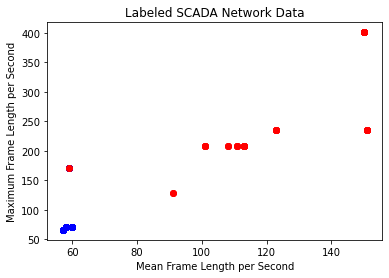

In [147]:
plt.scatter(n[0], n[1], c='b')
plt.scatter(m[0],m[1],c='r')
plt.xlabel("Mean Frame Length per Second")
plt.ylabel("Maximum Frame Length per Second")
plt.title("Labeled SCADA Network Data")

In [155]:
class kmeans:
    def __init__(self, data, k, N, n_iterations = 1000, convergence = 20, dimension = 1, distance_func = distance_between_points):
        self.data = data
        self.k = k
        self.N = N
        self.n_iterations = n_iterations
        self.convergence = convergence
        self.means = [[] for i in range(0,k)]
        self.previous_means = [[] for i in range(0,k)]
        self.std_dev = [0 for i in range(0,k)]
        self.no_changes = 0
        self.mean_list = []
        self.dimension = dimension
        self.distance_func = distance_func
    
    def initialize_means(self):
        if self.dimension>1:
            random_idx = np.random.randint(len(self.data), size = self.k)
            self.means = self.data[random_idx,:]
        else: 
            self.means = random.sample(sorted(self.data) ,self.k)
    
    def find_optimal_cluster(self, point):
        #calculate distance between each cluster and each mean
        distances = [self.distance_func(m, point) for m in self.means]
        return distances.index(min(distances))    
    
    def is_convergence(self):
        if np.array_equal(self.means, self.previous_means):
            self.no_changes += 1
            if self.no_changes >= self.convergence:
                return True
        else:
            self.previous_means = np.copy(self.means)
        return False
    
    def calculate_means(self):
        self.initialize_means()
        #print(self.means)
        self.previous_means = np.copy(self.means)
        for i in range(0, self.n_iterations):
            clusters = self.assign_points()
            self.means = self.update_means(clusters)
            if self.is_convergence():
                break
        self.means.sort()
        return self.means
   
    def calculate_means_averaged(self, n_runs = 50):
        for i in range(0, n_runs):
            self.initialize_means()
            #print(self.means)
            self.previous_means = np.copy(self.means)
            for i in range(0, self.n_iterations):
                clusters = self.assign_points()
                self.means = self.update_means(clusters)
                if self.is_convergence():
                    break
            self.means.sort()
            self.mean_list.append(self.means)
        return np.mean(self.mean_list, axis=0)
    
    def update_means(self, clusters):
        m = np.zeros((self.k, self.dimension))
        for idx, mean in enumerate(self.means):
            m[idx] = np.mean(clusters[idx], axis=0)
        return m
    
    def plot_one_convergence(self):
        self.initialize_means()
        mean_list_plotting = []
        s_dev_plotting = []
        for i in range(0, self.n_iterations):
            clusters = self.assign_points()
            means = self.update_means(clusters)
            s_dev = calculate_std_dev(means, self.data, self.k, self.N, self.distance_func)
            s_dev_plotting.append(s_dev)
            self.mean_list.append(means)
            
            mean_list_plotting.append(np.copy(means))
            self.means = means
            if(self.is_convergence()):
                break
        return mean_list_plotting, s_dev_plotting
    
    def assign_points(self):
        clusters = [[] for i in range(0,self.k)]
        for idx, data_point in enumerate(self.data):
            optimal_cluster = self.find_optimal_cluster(data_point)
            clusters[optimal_cluster].append(data_point)
        return clusters

In [14]:
def distance_between_points(a, b):
    try:
        dim = len(b)
        dim = len(a)
    except TypeError:
        return (a-b) * (a-b)
    s = 0
    for i in range(0, dim):
        s+=(a[i] - b[i]) * (a[i] - b[i])
    return s

In [79]:
def get_assignments(means, data, k):
    assignments = [[] for i in range(0,k)]
    for idx, data_point in enumerate(data):
        distances = [distance_between_points(data_point, m) for m in means]
        optimal_cluster_id = distances.index(min(distances))
        #print(f" data point {data_point} -> optimal {optimal_cluster_id} = {means[optimal_cluster_id]}")
        assignments[optimal_cluster_id].append(idx)
    return assignments